# Завдання
Побудова моделі прогнозування щоденної кількості броньованих автомобілів без скасування на період січень 2019 року – лютий 2019 року.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from translate import Translator

# Завантажемо опис до колонок

In [2]:
description = pd.read_csv('columns_description.csv', encoding= 'cp932')
# подивимось на загальну форму датафрейму
# look at DataFrame
description.shape # Out: (227, 5)
description.head(2)

,Unnamed: 0,Table,Row(JP),Row(EN),Description
0,1,rakuten_{shop}.csv,予約ステータス,booking_status,"status of booking (""noshow""=no show up, ""キャンセル..."
1,2,rakuten_{shop}.csv,楽天予約番号,rakuten_booking_number,booking number created by OTA


In [3]:
# також поглянемо чиє пропущені значення
# look at missing data
description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   227 non-null    int64 
 1   Table        227 non-null    object
 2   Row(JP)      227 non-null    object
 3   Row(EN)      227 non-null    object
 4   Description  227 non-null    object
dtypes: int64(1), object(4)
memory usage: 9.0+ KB


In [4]:
# Які файли описує завантажений датафрейм?
# Get description files
description.Table.unique()

array(['rakuten_{shop}.csv', 'jalan_{shop}.csv', 'skyticket_{shop}.csv',
       'bestpricerentacar_{shop}.csv', 'tocoo_{shop}.csv'], dtype=object)

<p style="color:blue"><b>серед описаних таблиць нас цікавлять 'rakuten_{shop}.csv' та 'jalan_{shop}.csv'</b></p>

# Порівняємо колонки 
### для "rakuten_{shop}.csv" та для "jalan_{shop}.csv"

In [5]:
# відберемо спочатку "rakuten_{shop}.csv" 
# та поглянемо на кількість колонок та чи є відмінність між "jalan_{shop}.csv"
# what difference about rakuten and jalan csv files columns
rakuten_csv = description.query('Table=="rakuten_{shop}.csv"')
rakuten_csv.nunique()

Unnamed: 0     48
Table           1
Row(JP)        48
Row(EN)        48
Description    44
dtype: int64

In [6]:
jalan_csv = description.query('Table=="jalan_{shop}.csv"')
jalan_csv.nunique()

Unnamed: 0     46
Table           1
Row(JP)        46
Row(EN)        46
Description    38
dtype: int64

# Які відмінності?

In [7]:
def retrieve_name(var):
    """Gets the name of var. Does it from the out most frame inner-wards
    :param var: variable to get name from.
    :return: string
    from https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string/19201952#19201952
    """
    import inspect
    for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]
            
def difference_cols(col1, col2):
    name_col1 , name_col2 = [retrieve_name(col) for col in [col1, col2]]
    result = set(col1).difference(set(col2))
    if result:
        print(f'В {name_col2} відсутні колонки {name_col1}: {result}')
    else:
        print(f'В {name_col1} присутні всі колонки {name_col2}')
    result2 = set(col2).difference(set(col1))
    print('==============')
    if result2:
        print(f'В {name_col1} відсутні колонки {name_col2}: {result2}')
    else:
        print(f'В {name_col2} присутні всі колонки {name_col1}')
    return result.union(result2)
jalan_rowEN = jalan_csv['Row(EN)'].unique()
rakuten_rowEN = rakuten_csv['Row(EN)'].unique()
not_use = difference_cols(jalan_rowEN, rakuten_rowEN)

В rakuten_rowEN відсутні колонки jalan_rowEN: {'final_total_amount', 'total_price', 'insurance', 'car_class', 'option_price', 'late_night_fee', 'booking_ number', 'dp_final_total_amount', 'return_shop', 'insurance_price', 'cuopon_name', 'additional_grant_points', 'system_usage_fee', 'basic_plan_price', 'cancellation_date_time', 'dp_last_update', 'cancellation_fee', 'status_of_booking', 'company_name', 'dp_operator_memo', 'departure_flight', 'total_option_price', 'grant_points', 'arrival_flight', 'plan_name', 'smoking', 'cuopon_code', 'cuopon_discount', 'payment_status', 'points', 'total_insurance_price', 'base_amount_calculation', 'plan_code', 'plan_classification', 'promotion_program', 'pickup_shop'}
В jalan_rowEN відсутні колонки rakuten_rowEN: {'company_car_class_code', 'point', 'detail_car_class_code', 'accommodation_address', 'payment_method', 'detail_car_class_name', 'options_total_fee', 'non_taxable_amount', 'subtotal_amount', 'booking_status', 'number_of_children', 'taxable_amo

# Які ж колонки спільні?

In [8]:
list_col = list(set(description.query('Table=="jalan_{shop}.csv" or Table=="rakuten_{shop}.csv"')['Row(EN)'].unique())-not_use)
list_col

['memo',
 'return_date_time',
 'request_date_time',
 'number_of_passengers',
 'drop_off_fee',
 'return_shop_code',
 'options',
 'transmission',
 'pickup_date_time',
 'pickup_shop_code']

**так щоб модель однаково працювала на даних наборах будемо застосовувати вищезгадані колонки, що вони описують?**

In [9]:
description = description.rename(columns = {'Row(EN)' : 'RowEN'})
description.query('RowEN in @list_col and Table in ("rakuten_{shop}.csv","jalan_{shop}.csv")')

,Unnamed: 0,Table,Row(JP),RowEN,Description
4,7,rakuten_{shop}.csv,予約受付日時,request_date_time,date and time of the request made
8,11,rakuten_{shop}.csv,乗車人数,number_of_passengers,total number of passengers including children
16,19,rakuten_{shop}.csv,貸渡日時,pickup_date_time,date and time to pick up cars
17,20,rakuten_{shop}.csv,貸渡営業所コード,pickup_shop_code,code of shop where to pick up cars
19,22,rakuten_{shop}.csv,返却日時,return_date_time,date and time to return cars
20,23,rakuten_{shop}.csv,返却営業所コード,return_shop_code,code of shop where to return cars
25,28,rakuten_{shop}.csv,AT/MT区分,transmission,"""AT""=automatic transmission, ""MT""=manual trans..."
29,32,rakuten_{shop}.csv,乗捨料金,drop_off_fee,additional fee to return the car to another shop
40,43,rakuten_{shop}.csv,備考,memo,memo
41,44,rakuten_{shop}.csv,付帯サービス,options,Show which options are included. Shows option ...


дата та час виконаного запросу - request_date_time - 予約受付日時

загальна кількість пасажирів, включно з дітьми - number_of_passengers - 乗車人数

дата та час отримання автомобіля - pickup_date_time - 貸渡日時

код магазину де забрати авто - pickup_shop_code - 貸渡営業所コード

дата та час повернення автомобіля - return_date_time - 返却日時

код магазину куди здати авто - return_shop_code - 返却営業所コード

автоматична або ручна коробка передач - transmission - AT/MT区分

додаткова плата за повернення авто в інший магазин - drop_off_fee - 乗捨料金

памятка - memo - 備考

опис опцій , які включені - options - 付帯サービス

Скоріше за все серед даного переліку корисну інформацію для побудови моделі несе змінна "貸渡日時" - дата та час отримання автомобіля

## Поглянемо на наповнення таблиць jalan та rakuten

In [10]:
jalan = pd.read_csv('jalan_shinchitose.csv', encoding= 'cp932')
print(jalan.shape)
jalan.head(1)

(1648, 46)


,事業者名,ステータス,精算,予約番号,企画区分,申込日,キャンセル日,貸出日時,貸出営業所,貸出営業所コード,...,利用クーポン金額,計算基準額,システム利用料,販促プログラム,ポイント付与料,ポイント追加付与料,料金プランコード,メモ,DPオペレーターメモ,DP用最終更新日時
0,ニコニコレンタカー,予約成立,済,R08EYWXP,じゃらん,2016/2/17 0:28,NaN,2016/3/20 8:00,新千歳空港店（ニコレンお客様大賞受賞店）,chitose,...,1000.0,6481,777,0.0,129.0,0.0,SCS01,NaN,NaN,NaN


In [11]:
# створимо словник-перекладач
# create translator columns
translate = dict(zip(description['Row(JP)'], description['RowEN'])) # RowEN

In [12]:
# перейменуємо колонки таблиці jalan
# rename jalan columns
for JP in jalan.columns.to_list():
    jalan = jalan.rename(columns = {JP:translate[JP]})

In [13]:
jalan.head(1)

,company_name,status,payment_status,booking_number,plan_classification,request_date_time,cancelled_date_time,pickup_date_time,pickup_shop,pickup_shop_code,...,cuopon_discount,base_amount_calculation,system_usage_fee,promotion_program,grant_points,additional_grant_points,plan_code,memo,dp_operator_memo,dp_last_update
0,ニコニコレンタカー,予約成立,済,R08EYWXP,じゃらん,2016/2/17 0:28,NaN,2016/3/20 8:00,新千歳空港店（ニコレンお客様大賞受賞店）,chitose,...,1000.0,6481,777,0.0,129.0,0.0,SCS01,NaN,NaN,NaN


In [14]:
# схоже колонка status відповідає booking_status booking status ("キャンセル"=cancelled, "予約"=booked, "成約"=confirmed)
jalan.status.unique() # ['Reservation successful', 'No visitor', 'Cancellation (reserved person's circumstances)']

array(['予約成立', '来店なし', 'キャンセル（予約者都合）'], dtype=object)

In [15]:
# перейменуємо колонки таблиці rakuten
# rename rakuten columns
rakuten = pd.read_csv('rakuten_shinchitose.csv', encoding= 'cp932')
for JP in rakuten.columns.to_list():
    rakuten= rakuten.rename(columns = {JP:translate[JP]})

In [16]:
rakuten.head(1)

,booking_status,rakuten_booking_number,company_booking_number,rakupack_booking_number,request_date_time,request_confirmed_date_time,cancel_request_date_time,cancellation_day_time,namber_of_passengers,number_of_children,...,non_taxable_amount,cancel_fee,memo,options,cancellation_reason,mobile_career,mobile_model,cancellation_classification,answer,payment_method
0,キャンセル済（予約直後）,RC32457434637117616,NaN,NaN,2016/2/16 17:41,NaN,2016/2/16 17:47,NaN,3,0,...,0,0,NaN,"免責補償制度 x 1, ＥＴＣ x 1, カーナビキャンペーン用 x 1, 喫煙車 x 1,...",NaN,NaN,NaN,NaN,NaN,オンラインカード決済


In [17]:
# порівняємо стовбці:
jalan_columns_list = jalan.columns.to_list()
rakuten_columns_list = rakuten.columns.to_list()
n_u = difference_cols(jalan_columns_list, rakuten_columns_list)

В rakuten_columns_list відсутні колонки jalan_columns_list: {'final_total_amount', 'total_price', 'insurance', 'car_class', 'option_price', 'status', 'late_night_fee', 'dp_final_total_amount', 'return_shop', 'insurance_price', 'cuopon_name', 'additional_grant_points', 'system_usage_fee', 'basic_plan_price', 'dp_last_update', 'cancellation_fee', 'booking_number', 'company_name', 'dp_operator_memo', 'departure_flight', 'total_option_price', 'grant_points', 'arrival_flight', 'plan_name', 'smoking', 'cuopon_code', 'cuopon_discount', 'payment_status', 'cancelled_date_time', 'points', 'total_insurance_price', 'base_amount_calculation', 'plan_code', 'plan_classification', 'promotion_program', 'pickup_shop'}
В jalan_columns_list відсутні колонки rakuten_columns_list: {'company_car_class_code', 'point', 'detail_car_class_code', 'accommodation_address', 'payment_method', 'detail_car_class_name', 'options_total_fee', 'non_taxable_amount', 'subtotal_amount', 'booking_status', 'number_of_children',

In [18]:
jalan_columns_list == rakuten_columns_list

False

In [19]:
# однакові колонки
set(jalan_columns_list+rakuten_columns_list)-n_u

{'drop_off_fee',
 'memo',
 'namber_of_passengers',
 'options',
 'pickup_date_time',
 'pickup_shop_code',
 'request_date_time',
 'return_date_time',
 'return_shop_code',
 'transmission'}

## Як видно між колонками файлів jalan та rakuten багато відмінностей

Розглянемо інші колонки які могли б нести цінну інформацію

та бачимо що важливою є колонка booking_status з наступними значеннями:

"予約確認済"=confirmed booking - підтверджене бронювання

"予約確認済（料金変更あり）"=confirmed booking with price changes - підтверджене бронювання зі зміною ціни

для навчання моделі не менш важливими є значення ВІДМІНИ БРОНЮВАННЯ

"キャンセル確認済"=confirmed cancellation - підтверджена відміна

"キャンセル済（管理画面より）"=cancelled by admin - відмінено адміністратором

"キャンセル済（予約直後）"=cancelled right after booking - відміна відразу після бронювання

"キャンセル未確認"=unconfirmed cancellation - не підтверджена відміна


In [20]:
# from IPython.core.display import display, HTML
# display(HTML(description[['RowEN', 'Description']].to_html()))

In [21]:
# Подивимось на пропущені значення 
jalan[['status', 'booking_number', 'request_date_time']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648 entries, 0 to 1647
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   status             1648 non-null   object
 1   booking_number     1648 non-null   object
 2   request_date_time  1648 non-null   object
dtypes: object(3)
memory usage: 38.8+ KB


In [22]:
rakuten[['booking_status','request_date_time','rakuten_booking_number']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   booking_status          3983 non-null   object
 1   request_date_time       3983 non-null   object
 2   rakuten_booking_number  3983 non-null   object
dtypes: object(3)
memory usage: 93.5+ KB


Розглянемо ще колонки 'booking_number' та 'rakuten_booking_number' - можливо для одного замовлення бути два значення замовлено та відхилено

In [23]:
jalan.booking_number.nunique() # всі значення унікальні!!!

1648

In [24]:
rakuten.rakuten_booking_number.nunique() # всі значення унікальні!!!

3983

In [25]:
rakuten.booking_status.unique()

array(['キャンセル済（予約直後）', '予約確認済', 'キャンセル確認済', 'キャンセル済（管理画面より）', '予約未確認',
       'キャンセル未確認', '予約確認済（料金変更あり）'], dtype=object)

# тож для подальшого аналізу: 
використаємо незалежні змінні `rakuten.booking_status` та `jalan.status` які вказують на кількість авто які було замовлено, та залежні змінні  `jalan.request_date_time` та `rakuten.request_date_time`

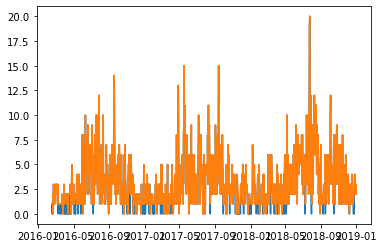

In [26]:
# підрахуємо кількість замовлених авто по дням сгрупувавши за датою
df_rakuten = pd.DataFrame()

booked = []
for i in rakuten.booking_status:
    if i in ["予約確認済", "予約確認済（料金変更あり）"]:
        booked.append(1)
    else:
        booked.append(0)

df_rakuten['booking_status'] = booked        
df_rakuten['date'] = pd.to_datetime(rakuten['request_date_time'], format='%Y.%m.%d', dayfirst= True)

df_rakuten['just_date'] = df_rakuten['date'].dt.date
# Групування через суму не підходить так як не воаховуються дні в яку не було замовлень ~ 100 днів за 3 роки
# ==>>> dfs = df_rakuten.groupby('just_date').sum().sort_values(by='just_date', ascending=False)
dfs = df_rakuten.groupby('just_date').sum().sort_values(by='just_date', ascending=False)
df = df_rakuten[(df_rakuten['booking_status']==1)]\
.groupby(pd.Grouper(key='date', freq='D')) ['date'].count().to_frame()
plt.plot(df)
plt.plot(dfs)

In [27]:
df['DATE'] = df.index
rak = pd.DataFrame.from_dict(df.values).rename(columns= {1:'date',0:'count_car'})
rak
rak['just_date'] = rak.date.dt.date # створимо колонку за якою будемо зєднувати святкові дні

# Додамо святкові дні

In [28]:
holidays = pd.read_csv('holidays_Japan.csv')
holidays['date'] = pd.to_datetime(holidays['day'])
holidays['just_date'] = holidays['date'].dt.date
hol = holidays[['Japan', 'just_date']]
rak = rak.merge(hol, on=['just_date'])
rak

,count_car,date,just_date,Japan
0,1,2016-02-16,2016-02-16,0
1,0,2016-02-17,2016-02-17,0
2,0,2016-02-18,2016-02-18,0
3,1,2016-02-19,2016-02-19,0
4,2,2016-02-20,2016-02-20,0
...,...,...,...,...
1045,2,2018-12-27,2018-12-27,0
1046,2,2018-12-28,2018-12-28,0
1047,2,2018-12-29,2018-12-29,0
1048,3,2018-12-30,2018-12-30,0


# Додамо аналогічним чином погодні дані

In [29]:
weather = pd.read_csv('weather_Hokkaido.csv')
weather.columns # Out: ['date', 'city_id', 'city', 'district', 'conditions', 'high_temp','low_temp', 'rain_probability']
weather['date'] = pd.to_datetime(holidays['day'])
weather['just_date'] = weather['date'].dt.date
weather = weather[['high_temp', 'low_temp', 'rain_probability', 'just_date']]
rak = rak.merge(weather, on=['just_date'])

In [30]:
rak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050 entries, 0 to 1049
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   count_car         1050 non-null   object        
 1   date              1050 non-null   datetime64[ns]
 2   just_date         1050 non-null   object        
 3   Japan             1050 non-null   int64         
 4   high_temp         1050 non-null   int64         
 5   low_temp          1050 non-null   int64         
 6   rain_probability  1050 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 65.6+ KB


In [31]:
rak['count_car'] = rak['count_car'].astype('int64')
rak['Japan'] = rak['Japan'].astype('object') # святкові дні це категоріальний признак з двома градаціями
rak.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050 entries, 0 to 1049
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   count_car         1050 non-null   int64         
 1   date              1050 non-null   datetime64[ns]
 2   just_date         1050 non-null   object        
 3   Japan             1050 non-null   object        
 4   high_temp         1050 non-null   int64         
 5   low_temp          1050 non-null   int64         
 6   rain_probability  1050 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 65.6+ KB


# Розглянемо необхідну інформацію про розподіл числових змінних.

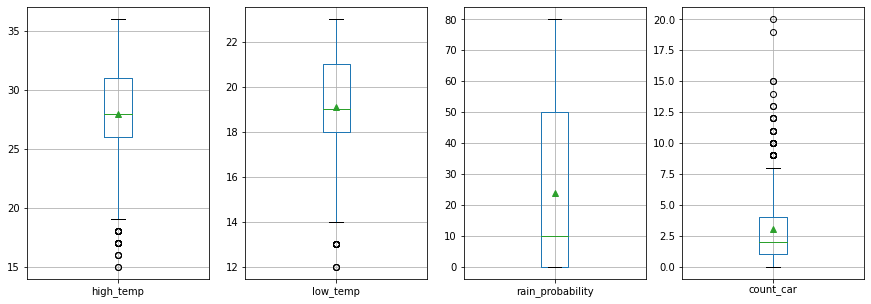

In [32]:
rak_features = rak[['high_temp', 'low_temp', 'rain_probability', 'count_car']]
fig, axs = plt.subplots(ncols=len(rak_features.columns), figsize=(15,5))
for col_name, ax in zip(rak_features.columns, axs):
    rak_features.boxplot(column=col_name, ax=ax, showmeans=True)

In [33]:
# rak_fearche.describe()

# Як розподіляються значення в залежності від часу

Text(0.5, 1.0, 'Максимальне значення температури')

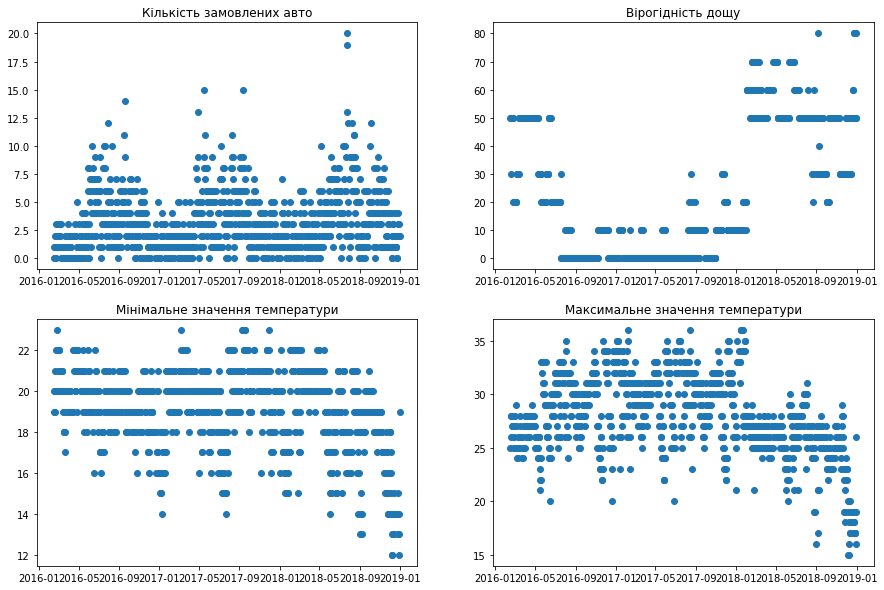

In [34]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
axs[0, 0].scatter(rak.date, rak.count_car)
axs[0, 0].set_title('Кількість замовлених авто')
axs[0, 1].scatter(rak.date, rak.rain_probability)
axs[0, 1].set_title('Вірогідність дощу')
axs[1, 0].scatter(rak.date, rak.low_temp)
axs[1, 0].set_title('Мінімальне значення температури')
axs[1, 1].scatter(rak.date, rak.high_temp)
axs[1, 1].set_title('Максимальне значення температури')

# Як корелюють отримані дані

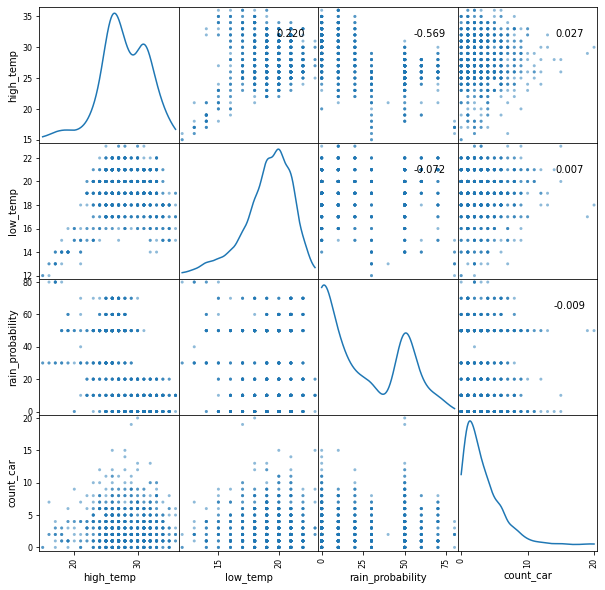

In [35]:
rak_features = rak[['high_temp', 'low_temp', 'rain_probability', 'Japan', 'count_car']]
axes = pd.plotting.scatter_matrix(rak_features, figsize=(10,10), diagonal='kde', grid=True)
corr = rak_features.corr().values
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

# Проведем класичні тести на перевірку нормальності розподілу наших змінних

In [36]:
import scipy.stats as stats
from scipy.stats import anderson, kstest, shapiro, chisquare
from statsmodels.stats.diagnostic import lilliefors

def conclusions(test):
    def wraper(sample):
        statistic, pvalue = test(sample)
        if pvalue < 0.05:
            print(f'{statistic=} {pvalue=} < 0.05, data does NOT look NORMAL (reject H0)')
            print('!!!')
        else:
            print(f'{statistic=:0.2f} {pvalue=:0.2f} > 0.05, data looks NORMAL (fail to reject H0)')
    return wraper

# Критерій Шапіро-Уїлка        
@conclusions        
def Shapiro(sample):
    print('ShapiroResult')
    statistic, pvalue = stats.shapiro(sample)
    return statistic, pvalue

# Критерій Колмогорова-Смирнова 
@conclusions
def KS(sample):
    print('KstestResult')
    statistic, pvalue = stats.kstest(sample, 'norm')
    return statistic, pvalue

# Критерій Лілієфорса
@conclusions
def Lilliefors_test(sample):
    print('LillieforsResult')
    statistic, pvalue = lilliefors(sample)
    return statistic, pvalue
    
# Критерій Андерсона-Дарлінга
def Anderson_Darling_test(sample):
    print('AndersonDarlingResult')
    result = anderson(sample)
    print('Statistic: %.3f' % result.statistic)
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
            print('!!!')

In [37]:
rak_features = rak[['high_temp', 'low_temp', 'rain_probability', 'count_car']]
for feature in rak_features.columns:
    print(f'========================={feature}=========================')
    KS(rak_features[f'{feature}'])
    Lilliefors_test(rak_features[f'{feature}'])
    Shapiro(rak_features[f'{feature}'])
    Anderson_Darling_test(rak_features[f'{feature}'])
# ВСІ ТЕСТИ ГОВОРЯТЬ ПРО НИЗЬКУ ІМОВІРНІСТЬ ТОГО ЩО ДАНІ РОЗПОДІЛЕНІ НОРМАЛЬНО

=========================high_temp=========================
KstestResult
statistic=1.0 pvalue=0.0 < 0.05, data does NOT look NORMAL (reject H0)
!!!
LillieforsResult
statistic=0.08250271080241489 pvalue=0.0009999999999998899 < 0.05, data does NOT look NORMAL (reject H0)
!!!
ShapiroResult
statistic=0.9732508063316345 pvalue=5.339691362682419e-13 < 0.05, data does NOT look NORMAL (reject H0)
!!!
AndersonDarlingResult
Statistic: 7.663
15.000: 0.574, data does not look normal (reject H0)
!!!
10.000: 0.654, data does not look normal (reject H0)
!!!
5.000: 0.784, data does not look normal (reject H0)
!!!
2.500: 0.915, data does not look normal (reject H0)
!!!
1.000: 1.088, data does not look normal (reject H0)
!!!
=========================low_temp=========================
KstestResult
statistic=1.0 pvalue=0.0 < 0.05, data does NOT look NORMAL (reject H0)
!!!
LillieforsResult
statistic=0.16711214238042899 pvalue=0.0009999999999998899 < 0.05, data does NOT look NORMAL (reject H0)
!!!
ShapiroRes

In [38]:
rak_features

,high_temp,low_temp,rain_probability,count_car
0,25,19,50,1
1,26,20,50,0
2,28,21,50,0
3,28,20,30,1
4,28,19,50,2
...,...,...,...,...
1045,17,13,80,2
1046,17,13,80,2
1047,16,12,80,2
1048,19,14,50,3


# ПОШИРЕНІ ПЕРЕТВОРЕННЯ

[link](https://books.irrp.org.ua/data-design/preobrazovaniya-dannyh/)

<div class="vc_row wpb_row section vc_row-fluid" style=" text-align:left;"><div class=" full_section_inner clearfix"><div class="wpb_column vc_column_container vc_col-sm-12"><div class="vc_column-inner "><div class="wpb_wrapper"><div class="wpb_vc_table wpb_content_element"><table class="vc-table-plugin-theme-classic_orange"><tbody><tr class="vc-th"><td style="text-align:left;background-color:#eeb11e;" class="vc_table_cell"><span class="vc_table_content">Метод</span></td><td style="text-align:left;background-color:#eeb11e;" class="vc_table_cell"><span class="vc_table_content">Математична операція</span></td><td style="text-align:left;background-color:#eeb11e;" class="vc_table_cell"><span class="vc_table_content">Підходить для:</span></td><td style="text-align:left;background-color:#eeb11e;" class="vc_table_cell"><span class="vc_table_content">Не підходить для::</span></td></tr><tr><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Логарифм</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">ln(x)<br>
log10(x)</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Даних, зміщених праворуч</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Нульових значень</span></td></tr><tr><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Квадратний корінь</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">√x</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content"> особливо добре працює зі ступенями 10 вищого порядку (наприклад, 1000, 100000)</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Негативних значень</span></td></tr><tr><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Квадрат</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">x²</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Даних, зміщених праворуч</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Негативних значень</span></td></tr><tr><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Корінь кубічний</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">x⅓</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Даних, зміщених вліво</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Негативних значень</span></td></tr><tr><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Зворотний дріб</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">1/x</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Даних, зміщених праворуч</span></td><td style="text-align:left;" class="vc_table_cell"><span class="vc_table_content">Не таке ефективне при нормалізації, як логарифмічне перетворення</span></td></tr></tbody></table></div></div></div></div></div></div>

In [39]:
rak_features = rak[['high_temp', 'low_temp', 'rain_probability', 'count_car']]
import numpy as np
cube_root = lambda x: x**(1/3)
for feature in rak_features.columns:
    rak_features[f'{feature}'] = rak_features[f'{feature}'].apply(cube_root)
rak_features

,high_temp,low_temp,rain_probability,count_car
0,2.924018,2.668402,3.684031,1.000000
1,2.962496,2.714418,3.684031,0.000000
2,3.036589,2.758924,3.684031,0.000000
3,3.036589,2.714418,3.107233,1.000000
4,3.036589,2.668402,3.684031,1.259921
...,...,...,...,...
1045,2.571282,2.351335,4.308869,1.259921
1046,2.571282,2.351335,4.308869,1.259921
1047,2.519842,2.289428,4.308869,1.259921
1048,2.668402,2.410142,3.684031,1.442250


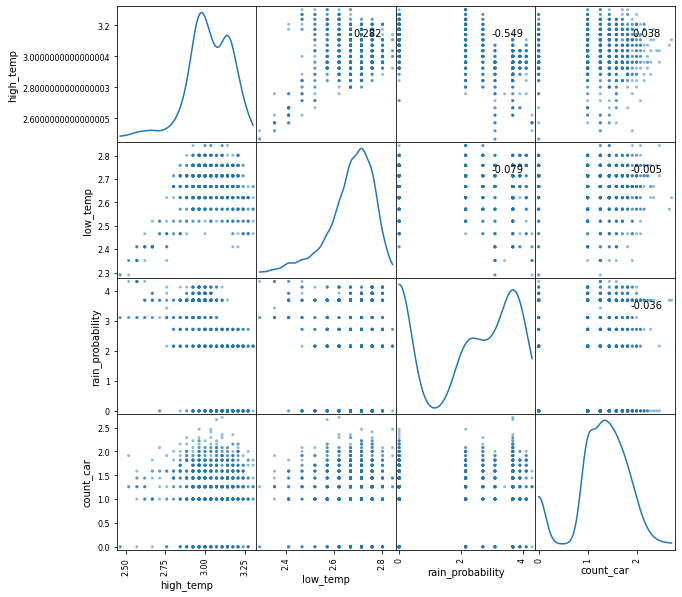

In [40]:
# rak_features = rak[['high_temp', 'low_temp', 'rain_probability', 'Japan', 'count_car']]
axes = pd.plotting.scatter_matrix(rak_features, figsize=(10,10), diagonal='kde', grid=True)
corr = rak_features.corr().values
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

In [41]:
for feature in rak_features.columns:
    print(f'========================={feature}=========================')
    KS(rak_features[f'{feature}'])
    Lilliefors_test(rak_features[f'{feature}'])
    Shapiro(rak_features[f'{feature}'])
    Anderson_Darling_test(rak_features[f'{feature}'])

=========================high_temp=========================
KstestResult
statistic=0.9931724769828082 pvalue=0.0 < 0.05, data does NOT look NORMAL (reject H0)
!!!
LillieforsResult
statistic=0.09162764400151097 pvalue=0.0009999999999998899 < 0.05, data does NOT look NORMAL (reject H0)
!!!
ShapiroResult
statistic=0.9539426565170288 pvalue=1.2293755959929497e-17 < 0.05, data does NOT look NORMAL (reject H0)
!!!
AndersonDarlingResult
Statistic: 9.860
15.000: 0.574, data does not look normal (reject H0)
!!!
10.000: 0.654, data does not look normal (reject H0)
!!!
5.000: 0.784, data does not look normal (reject H0)
!!!
2.500: 0.915, data does not look normal (reject H0)
!!!
1.000: 1.088, data does not look normal (reject H0)
!!!
=========================low_temp=========================
KstestResult
statistic=0.988972765666552 pvalue=0.0 < 0.05, data does NOT look NORMAL (reject H0)
!!!
LillieforsResult
statistic=0.18203137434255012 pvalue=0.0009999999999998899 < 0.05, data does NOT look NOR